Model performance is tested best when it is tasked to distinguish between "similar" objects. So I have tried to create some clusters of objects which are similar to one another. The number in parentheses is the label index.

**Round things**
- baseball (19), basketball (22), soccer ball (276), wheel (337), cookie (81), donut (96), moon (190), clock (76), pizza (228)

**Drinkware & containers**
- cup (90), mug (197), coffee cup (78), wine glass (340), vase (331), wine bottle (339), teapot (306)

**Slender handhelds & utensils (long thin stems + tip variations)**
- pencil (220), marker (183), toothbrush (317), screwdriver (257), fork (127), knife (166)

**Road vehicles (boxy cabins + wheels)**
- car (64), truck (326), pickup truck (223), bus (50), school bus (254), van (330)

**Watercraft (hulls/superstructure silhouettes)**
- sailboat (250), speedboat (278), canoe (63), cruise ship (89)

**Boxy appliances (rectangular)**
- microwave (188), oven (206), toaster (313), dishwasher (92), washing machine (333)

**Furniture**
- chair (71), couch (83), bed (28), bench (31), table (305)

**Apparel (necklines/hems/sleeves are subtle and often omitted)**
- t-shirt (304), sweater (300), jacket (160), pants (212), shorts (263)

**Pure shape/sign confusion (polygon sides vs labeled sign)**
- circle (74), octagon (203), stop sign (291)

### Prerequisites (uncomment to run)

#### Installations

In [1]:
# Assuming the virtual environment .tens-and-cuda is being used
%pip install tensorflow[and-cuda] numpy tqdm matplotlib


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /home/priyanka/doodle-vision/.tens-and-cuda/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


#### Data preprocessing

In [2]:
# # Step 1: Download QuickDraw dataset
# %python download_data.py

# # Step 2: Combine stroke data across different partitions (train, val, test).
# # The original data (e.g., airplanes.npz) is split into these partitions, 
# # which reduces the number of data points. We merge all partitions for a complete dataset.
# %python combine_strokes.py

# # Step 3: Convert each `.npy` and `.npz` file into individual sample files.
# # For example, `airplanes.npy` contains (N, 784), where N is the number of samples 
# # and each sample is a flattened 28x28 image (784 features). We split this into
# # individual `.npy` files like `airplanes/000001.npy`, `airplanes/000002.npy`, etc.
# # This allows us to load specific slices of data (e.g., airplanes[3012:33012]) 
# # without having to load the entire file, reducing memory usage and avoiding memory eviction issues.
# %python convert_to_individual_npys.py

### Imports

In [3]:
import datetime
import gc
import json
import math
import os
import pickle
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import (
    BackupAndRestore,
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)
from tensorflow.keras.layers import (
    LSTM,
    BatchNormalization,
    Bidirectional,
    Concatenate,
    Conv2D,
    Dense,
    DepthwiseConv2D,
    Dropout,
    GlobalAveragePooling2D,
    Input,
    MaxPooling2D,
    ReLU,
)
from tensorflow.keras.models import Model
from tqdm import tqdm

### GPU Configs

In [4]:
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1755733584.391885  288134 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19649 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


### Global Variables

In [5]:
# Files
DATA_DIR_IMAGES = "dataset/images"
DATA_DIR_STROKES = "dataset/combined_strokes"
LABELS_JSON    = "dataset/label_map.json"
PROCESSED_DATA_DIR = "dataset/processed"

# Data props
# Even though we're using only 50 classes, the labels of these classes are still taken from
# label_map.json, hence are out of 345. The NUM_CLASSES here is just used for creating the 
# one-hot vector
NUM_CLASSES = 345

# Data props (image)
IMG_HEIGHT     = 28
IMG_WIDTH      = 28
IMG_CHANNELS   = 1

# Data props (stroke)
MAX_STROKES_LEN = 130
STROKES_FEATURES = 3

# Training
SAMPLES_PER_CLASS = 30_000
SPLIT_RATIOS = (0.8, 0.1, 0.1) # train, val, test
BATCH_SIZE = 512
EPOCHS = 20

CONFUSING_LABELS_MAP = {
    "round": [19, 22, 276, 337, 81, 96, 190, 76, 228],
    "drinkware": [90, 197, 78, 340, 331, 339, 306],
    "slender": [220, 183, 317, 257, 127, 166],
    "vehicles": [64, 326, 223, 50, 254, 330],
    "watercraft": [250, 278, 63, 89],
    "appliances": [188, 206, 313, 92, 333],
    "furniture": [71, 83, 28, 31, 305],
    "apparel": [304, 300, 160, 212, 263],
    "shapes": [74, 203, 291],
}

In [6]:
with open(LABELS_JSON, 'r') as f:
    LABEL_MAP = json.load(f)
    
REV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}

In [7]:
FILTERED_LABEL_MAP = {}
for group, ids in CONFUSING_LABELS_MAP.items():
    FILTERED_LABEL_MAP[group] = {REV_LABEL_MAP[i]: i for i in ids if i in REV_LABEL_MAP}

### Disk Data Loader for Original Data

In [8]:
# Using the individual + in-memory mode for 50 classes
images = []
strokes = []

# Always list of integers
labels = []

for group, label_map in tqdm(FILTERED_LABEL_MAP.items(), desc="Building dataset"):
    for cls, label in tqdm(label_map.items(), desc=f"Building {group}"):
        image_files = sorted(
            glob(os.path.join(PROCESSED_DATA_DIR, "images", cls, "*.npy"))
        )
        stroke_files = sorted(
            glob(os.path.join(PROCESSED_DATA_DIR, "strokes", cls, "*.npy"))
        )

        N = min(len(image_files), len(stroke_files), SAMPLES_PER_CLASS)

        for i in range(N):
            image_path = image_files[i]
            stroke_path = stroke_files[i]

            images.append(np.load(image_path))
            strokes.append(np.load(stroke_path))
            labels.append(label)

print(f"[In-Memory Mode] Loaded {len(labels):,} samples.")


Building dataset: 100%|███████████████████████████████████████████████████████████████████| 9/9 [01:43<00:00, 11.45s/it]

[In-Memory Mode] Loaded 1,500,000 samples.


In [9]:
def data_generator(images, strokes, labels):
    for image, stroke, label in zip(images, strokes, labels):
        yield (
            image,
            stroke,
            tf.one_hot(label, depth=NUM_CLASSES),
        )

In [10]:
def format_sample(img, stroke, label):
    return {"stroke_input": stroke, "image_input": img}, label

output_signature = (
    tf.TensorSpec(shape=(28, 28, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(130, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(NUM_CLASSES,), dtype=tf.int32),
)

### Train, Val, and Test Splits

In [11]:
# Shuffle once and split
total = len(labels)
indices = np.arange(total)
np.random.seed(42)
np.random.shuffle(indices)

train_end = int(SPLIT_RATIOS[0] * total)
val_end = train_end + int(SPLIT_RATIOS[1] * total)

train_idx = indices[:train_end]
val_idx = indices[train_end:val_end]
test_idx = indices[val_end:]

# Train
train_images =  [images[i] for i in train_idx]
train_strokes = [strokes[i] for i in train_idx]
train_labels =  [labels[i] for i in train_idx]

# Val
val_images =  [images[i] for i in val_idx]
val_strokes = [strokes[i] for i in val_idx]
val_labels =  [labels[i] for i in val_idx]

# Test
test_images =  [images[i] for i in test_idx]
test_strokes = [strokes[i] for i in test_idx]
test_labels =  [labels[i] for i in test_idx]

In [12]:
def build_dataset(images, strokes, labels, is_shuffle=False):
    def gen():
        return data_generator(images, strokes, labels)

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=output_signature
    )

    if is_shuffle:
        ds = ds.shuffle(BATCH_SIZE * 10)

    ds = ds.repeat()
    ds = ds.map(format_sample, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    return ds.prefetch(tf.data.AUTOTUNE)

In [13]:
train_ds = build_dataset(train_images, train_strokes, train_labels, is_shuffle=True)
val_ds  = build_dataset(val_images, val_strokes, val_labels).take(math.ceil(len(val_labels) / BATCH_SIZE))
test_ds = build_dataset(test_images, test_strokes, test_labels).take(math.ceil(len(test_labels) / BATCH_SIZE))

### Models Building

In [14]:
def build_hybrid_model(num_classes):
    inp_str = Input(shape=(MAX_STROKES_LEN, STROKES_FEATURES), name="stroke_input")
    x = Bidirectional(LSTM(128, return_sequences=True))(inp_str)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(64))(x)
    x = Dense(128, activation="relu")(x)

    inp_img = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name="image_input")
    y = Conv2D(32, 3, activation="relu", padding="same")(inp_img)
    y = MaxPooling2D()(y)
    y = Conv2D(64, 3, activation="relu", padding="same")(y)
    y = BatchNormalization()(y)
    y = MaxPooling2D()(y)
    y = Conv2D(128, 3, activation="relu", padding="same")(y)
    y = BatchNormalization()(y)
    y = MaxPooling2D()(y)
    y = Conv2D(256, 3, activation="relu", padding="same")(y)
    y = GlobalAveragePooling2D()(y)
    y = Dense(128, activation="relu")(y)

    merged = Concatenate()([x, y])
    merged = Dropout(0.5)(merged)
    merged = Dense(256, activation="relu")(merged)
    merged = Dropout(0.3)(merged)
    out = Dense(num_classes, activation="softmax", dtype="float32")(merged)

    return Model(inputs=[inp_str, inp_img], outputs=out, name="hybrid_model")

hybrid_model = build_hybrid_model(num_classes=NUM_CLASSES)
hybrid_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"],
)

hybrid_model.summary()

Model: "hybrid_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        320 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 14, 14,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stroke_input        │ (None, 130, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 130, 256)  │    135,168 │ stroke_input[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 128) │     73,856 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 130, 256)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 128) │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 130, 256)  │    394,240 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 3, 3, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 130, 256)  │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 3, 3, 256) │    295,168 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 128)       │    164,352 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ conv2d_3[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,286,233 (4.91 MB)

 Trainable params: 1,285,849 (4.91 MB)

 Non-trainable params: 384 (1.50 KB)

In [15]:
# Depthwise + Pointwise block (as in LW-SketchNet)
def dw_pw_block(x, filters, stride=1):
    """
    Depthwise (9x9, stride) + Pointwise (1x1) conv + BN + ReLU, as in LW-SketchNet.
    """
    # Depthwise convolution (per-channel spatial filtering)
    x = DepthwiseConv2D(kernel_size=9, strides=stride, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Pointwise convolution (channel mixing)
    x = Conv2D(filters, kernel_size=1, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x


def build_lw_sketchnet_paper(num_classes=NUM_CLASSES):
    inp_img = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name="image_input")

    # Stem: standard conv (larger kernel, no downsample)
    x = Conv2D(64, kernel_size=9, strides=1, padding="same", use_bias=False)(inp_img)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Depthwise+Pointwise blocks
    x = dw_pw_block(x, 64, stride=1)   # 28x28x64
    x = dw_pw_block(x, 128, stride=2)   # 14x14x128
    x = dw_pw_block(x, 128, stride=1)   # 14x14x128
    x = dw_pw_block(x, 256, stride=2)   # 7x7x256
    x = dw_pw_block(x, 256, stride=1)   # 7x7x256
    x = dw_pw_block(x, 512, stride=2)   # 4x4x512
    x = dw_pw_block(x, 512, stride=1)   # 4x4x512

    # Global feature pooling
    x = GlobalAveragePooling2D()(x)     # -> 512-dim

    # Softmax classifier
    out = Dense(num_classes, activation="softmax", dtype="float32")(x)

    return Model(inputs=inp_img, outputs=out, name="LW-SketchNet")


# Build & compile
lw_sketchnet_model = build_lw_sketchnet_paper(num_classes=NUM_CLASSES)
lw_sketchnet_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"],
)
lw_sketchnet_model.summary()


Model: "LW-SketchNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 64)     │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 28, 28, 64)     │         5,184 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 14, 14, 64)     │         5,184 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 14, 14, 128)    │        10,368 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 829,721 (3.17 MB)

 Trainable params: 823,065 (3.14 MB)

 Non-trainable params: 6,656 (26.00 KB)

### Model Training and graph plotting

In [16]:
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [17]:
hybrid_model_name = f"hybrid_50_classes_{SAMPLES_PER_CLASS}_examples"
hybrid_callbacks = [
    ModelCheckpoint(f"models/{hybrid_model_name}.keras", monitor="val_accuracy", save_best_only=True),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
    MemoryCleanupCallback(),
    BackupAndRestore(backup_dir="./hybrid_50_training_backup"),
    TensorBoard(
        log_dir=f"./logs/hybrid_50/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}",
        histogram_freq=1,  # logs weights histograms every epoch
    ),
]

hybrid_history = hybrid_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=math.ceil(len(train_labels) / BATCH_SIZE),
    callbacks=hybrid_callbacks,
)

Epoch 1/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 364s 153ms/step - accuracy: 0.7640 - loss: 1.6445 - val_accuracy: 0.8728 - val_loss: 1.2570 - learning_rate: 0.0010
Epoch 2/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 357s 153ms/step - accuracy: 0.8624 - loss: 1.3185 - val_accuracy: 0.8895 - val_loss: 1.2035 - learning_rate: 0.0010
Epoch 3/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 358s 153ms/step - accuracy: 0.8809 - loss: 1.2566 - val_accuracy: 0.8923 - val_loss: 1.1894 - learning_rate: 0.0010
Epoch 4/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 358s 153ms/step - accuracy: 0.8906 - loss: 1.2222 - val_accuracy: 0.9001 - val_loss: 1.1671 - learning_rate: 0.0010
Epoch 5/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 359s 153ms/step - accuracy: 0.8982 - loss: 1.1975 - val_accuracy: 0.9043 - val_loss: 1.1558 - learning_rate: 0.0010
Epoch 6/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 359s 153ms/step - accuracy: 0.9033 - loss: 1.1817 - val_accuracy: 0.9051 - val_loss: 1.1518 - learning_rate: 0.0010
Epoch 7/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 363s 155ms

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [18]:
lw_sketchnet_model_name = f"lw_sketchnet_50_classes_{SAMPLES_PER_CLASS}_examples"
lw_sketchnet_callbacks = [
    ModelCheckpoint(f"models/{lw_sketchnet_model_name}.keras", monitor="val_accuracy", save_best_only=True),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
    MemoryCleanupCallback(),
    BackupAndRestore(backup_dir="./lw_sketchnet_50_training_backup"),
    TensorBoard(
        log_dir=f"./logs/lw_sketchnet_50/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}",
        histogram_freq=1,  # logs weights histograms every epoch
    ),
]

lw_sketchnet_history = lw_sketchnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=math.ceil(len(train_labels) / BATCH_SIZE),
    callbacks=lw_sketchnet_callbacks,
)

Epoch 1/20


/home/priyanka/doodle-vision/.tens-and-cuda/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: image_input
Received: inputs=['Tensor(shape=(None, 28, 28, 1))']
  warnings.warn(msg)


   3/2344 ━━━━━━━━━━━━━━━━━━━━ 3:04 79ms/step - accuracy: 0.0141 - loss: 5.7424  

I0000 00:00:1755740816.213572  288283 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 353s 145ms/step - accuracy: 0.7379 - loss: 1.6591 - val_accuracy: 0.7502 - val_loss: 1.6154 - learning_rate: 0.0010
Epoch 2/20
 653/2344 ━━━━━━━━━━━━━━━━━━━━ 3:41 131ms/step - accuracy: 0.7809 - loss: 1.5149

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [19]:
with open(f"history/{hybrid_model_name}_training_history.pkl", "wb") as f:
    pickle.dump(hybrid_history.history, f)

with open(f"history/{lw_sketchnet_model_name}_training_history.pkl", "wb") as f:
    pickle.dump(lw_sketchnet_history.history, f)

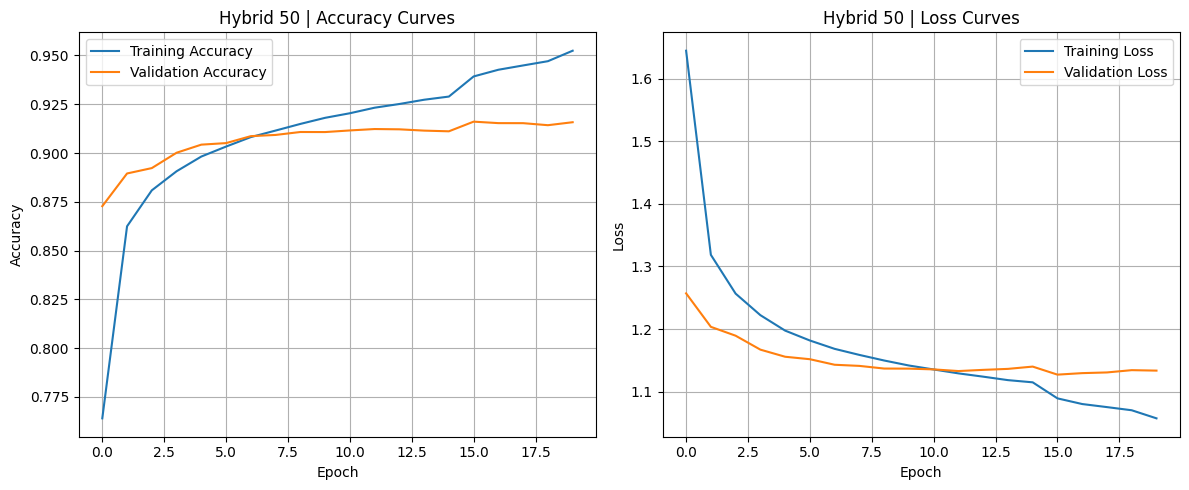

In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hybrid_history.history["accuracy"], label="Training Accuracy")
plt.plot(hybrid_history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Hybrid 50 | Accuracy Curves")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hybrid_history.history["loss"], label="Training Loss")
plt.plot(hybrid_history.history["val_loss"], label="Validation Loss")
plt.title("Hybrid 50 | Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

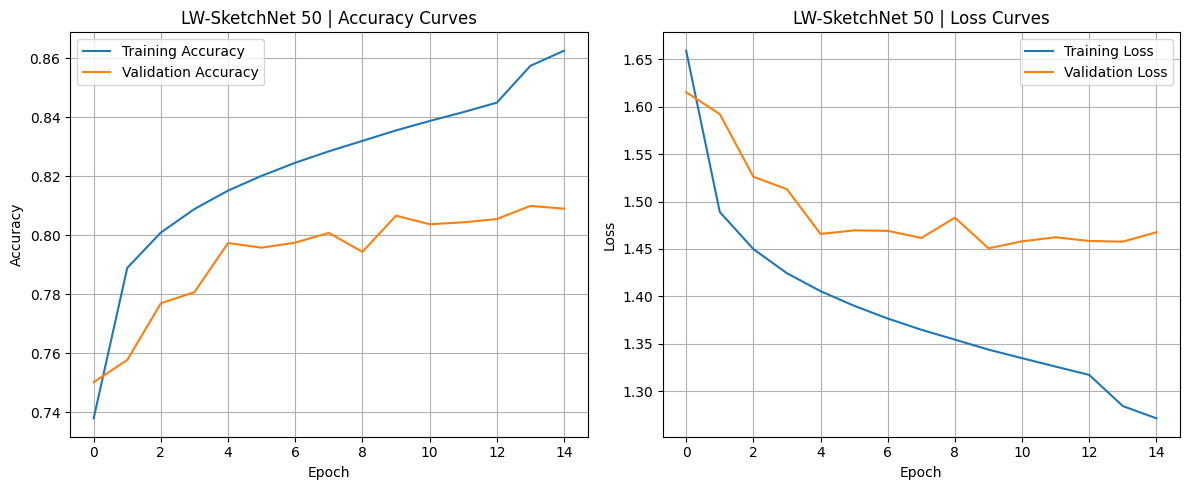

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(lw_sketchnet_history.history["accuracy"], label="Training Accuracy")
plt.plot(lw_sketchnet_history.history["val_accuracy"], label="Validation Accuracy")
plt.title("LW-SketchNet 50 | Accuracy Curves")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(lw_sketchnet_history.history["loss"], label="Training Loss")
plt.plot(lw_sketchnet_history.history["val_loss"], label="Validation Loss")
plt.title("LW-SketchNet 50 | Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Model Evaluation on Test Data

In [22]:
hybrid_eval_model = tf.keras.models.load_model(f"models/{hybrid_model_name}.keras")
hybrid_loss, hybrid_acc = hybrid_eval_model.evaluate(test_ds)
print(f"Test Loss: {hybrid_loss:.4f} | Test Accuracy: {hybrid_acc:.4f}")

293/293 ━━━━━━━━━━━━━━━━━━━━ 34s 114ms/step - accuracy: 0.9150 - loss: 1.1286
Test Loss: 1.1286 | Test Accuracy: 0.9150


In [23]:
lw_sketchnet_eval_model = tf.keras.models.load_model(f"models/{lw_sketchnet_model_name}.keras")
lw_sketchnet_loss, lw_sketchnet_acc = lw_sketchnet_eval_model.evaluate(test_ds)
print(f"Test Loss: {lw_sketchnet_loss:.4f} | Test Accuracy: {lw_sketchnet_acc:.4f}")

293/293 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.8092 - loss: 1.4585
Test Loss: 1.4585 | Test Accuracy: 0.8092


### Model Evaluation on Complete (30K samples) Data

In [24]:
ds = build_dataset(images, strokes, labels).take(math.ceil(len(labels) / BATCH_SIZE))

In [25]:
hybrid_loss, hybrid_acc = hybrid_eval_model.evaluate(ds)
print(f"Test Loss: {hybrid_loss:.4f} | Test Accuracy: {hybrid_acc:.4f}")

2930/2930 ━━━━━━━━━━━━━━━━━━━━ 335s 114ms/step - accuracy: 0.9469 - loss: 1.0511
Test Loss: 1.0511 | Test Accuracy: 0.9469


In [26]:
lw_sketchnet_loss, lw_sketchnet_acc = lw_sketchnet_eval_model.evaluate(ds)
print(f"Test Loss: {lw_sketchnet_loss:.4f} | Test Accuracy: {lw_sketchnet_acc:.4f}")

2930/2930 ━━━━━━━━━━━━━━━━━━━━ 325s 111ms/step - accuracy: 0.8443 - loss: 1.3297
Test Loss: 1.3297 | Test Accuracy: 0.8443


## Confusion Matrices

In [27]:
# Using the individual + in-memory mode for LW-SketchNet 50 and Hybrid 50 inference
# Load with exactly 3000 samples class
conf_images = []
conf_strokes = []

# Always list of integers
conf_labels = []

for group, label_map in tqdm(FILTERED_LABEL_MAP.items(), desc="Building dataset"):
    for cls, label in tqdm(label_map.items(), desc=f"Building {group}"):
        image_files = sorted(
            glob(os.path.join(PROCESSED_DATA_DIR, "images", cls, "*.npy"))
        )
        stroke_files = sorted(
            glob(os.path.join(PROCESSED_DATA_DIR, "strokes", cls, "*.npy"))
        )

        N = min(len(image_files), len(stroke_files), 3_000)

        for i in range(N):
            image_path = image_files[i]
            stroke_path = stroke_files[i]

            conf_images.append(np.load(image_path))
            conf_strokes.append(np.load(stroke_path))
            conf_labels.append(label)

print(f"[In-Memory Mode] Loaded {len(conf_labels):,} samples.")

Building dataset: 100%|███████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.74s/it]

[In-Memory Mode] Loaded 150,000 samples.


In [28]:
# Without the `.repeat()` as in confusion_matrix.ipynb
def build_dataset(images, strokes, labels, is_shuffle=False):
    def gen():
        return data_generator(images, strokes, labels)

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=output_signature
    )

    if is_shuffle:
        ds = ds.shuffle(BATCH_SIZE * 10)

    ds = ds.map(format_sample, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    return ds.prefetch(tf.data.AUTOTUNE)

In [29]:
conf_ds = build_dataset(conf_images, conf_strokes, conf_labels).take(math.ceil(len(conf_labels) / BATCH_SIZE))

### Load the Models

In [30]:
hybrid_saved_model = tf.keras.models.load_model(f"models/{hybrid_model_name}.keras")
lw_sketchnet_saved_model = tf.keras.models.load_model(f"models/{lw_sketchnet_model_name}.keras")

### Run Predictions

In [31]:
hybrid_y_pred_probs = hybrid_saved_model.predict(conf_ds, verbose=1)
hybrid_y_pred = np.argmax(hybrid_y_pred_probs, axis=1)

293/293 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step


/home/priyanka/doodle-vision/.tens-and-cuda/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [32]:
lw_sketchnet_y_pred_probs = lw_sketchnet_saved_model.predict(conf_ds, verbose=1)
lw_sketchnet_y_pred = np.argmax(lw_sketchnet_y_pred_probs, axis=1)

/home/priyanka/doodle-vision/.tens-and-cuda/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: image_input
Received: inputs=['Tensor(shape=(512, 28, 28, 1))']
  warnings.warn(msg)


293/293 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step


In [33]:
y_true = np.array(conf_labels)

In [34]:
class_names_50 = []
class_ids_50 = []

for group, label_map in FILTERED_LABEL_MAP.items():
    class_names = list(label_map.keys())
    class_ids = list(label_map.values())

    class_names_50.extend(class_names)
    class_ids_50.extend(class_ids)

### Plot Confusion Matrices

In [35]:
def plot_confusion_matrix(
    y_true, y_pred, class_ids, class_names, title, figsize=(8, 6)
):
    cm = confusion_matrix(y_true, y_pred, labels=class_ids)
    accuracy = np.trace(cm) / np.sum(cm)
    
    plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=class_names,
        yticklabels=class_names,
        cmap="Blues",
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{title}\nAccuracy: {accuracy:.2%}")  
    plt.show()

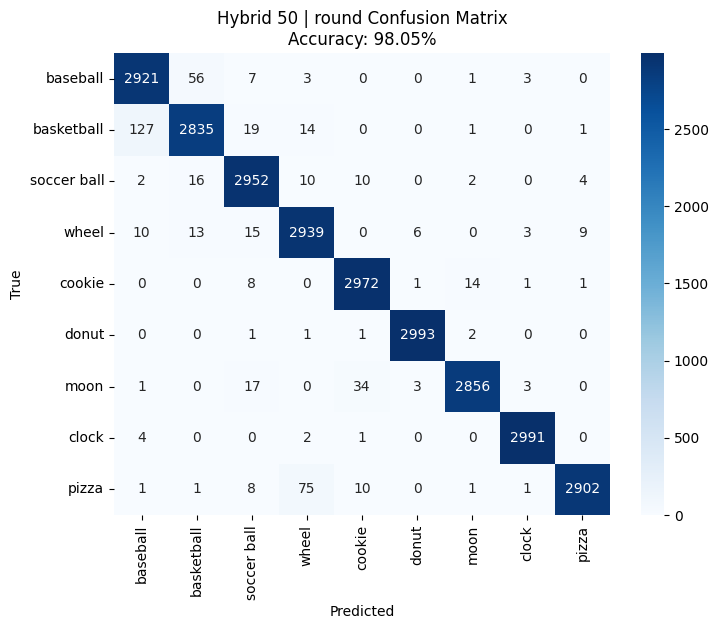

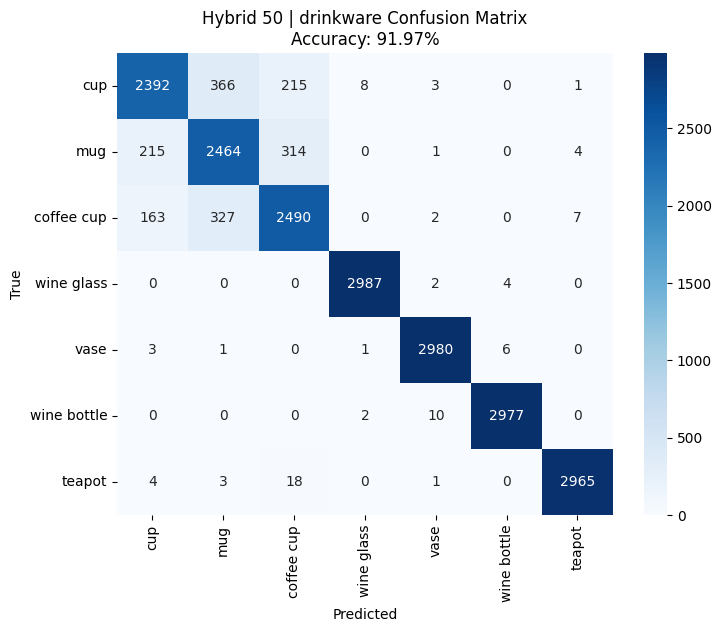

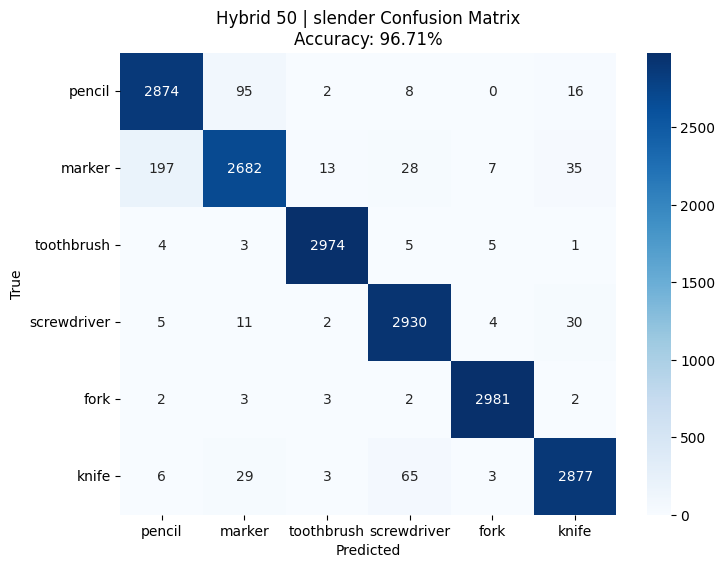

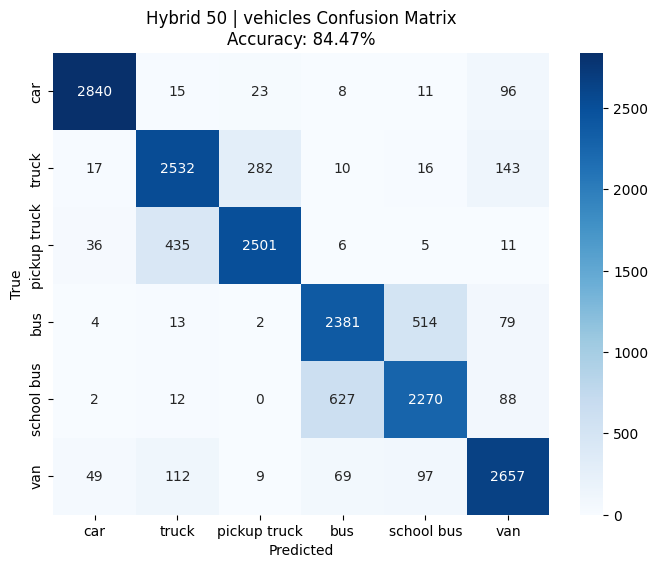

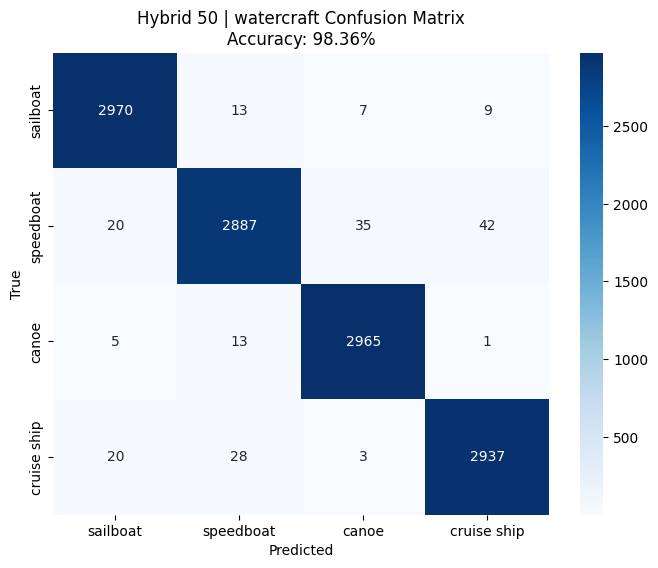

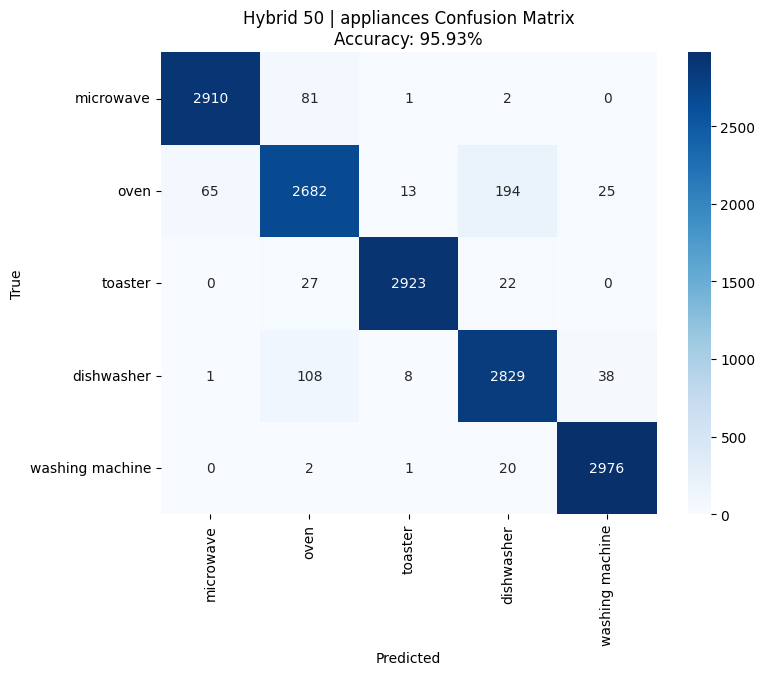

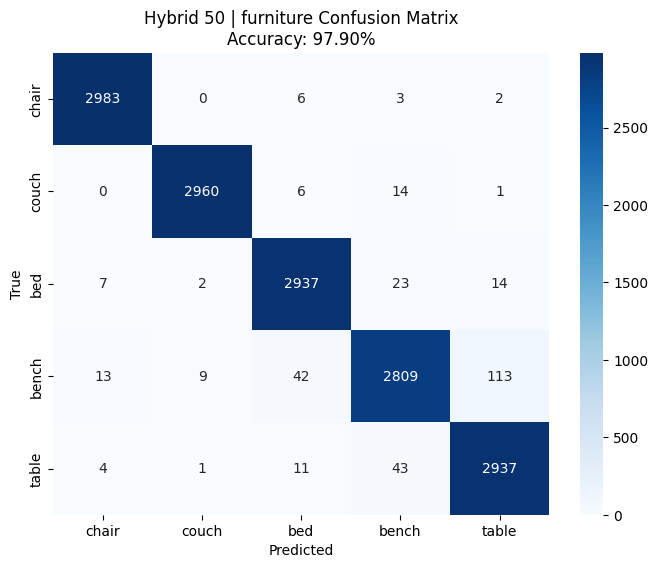

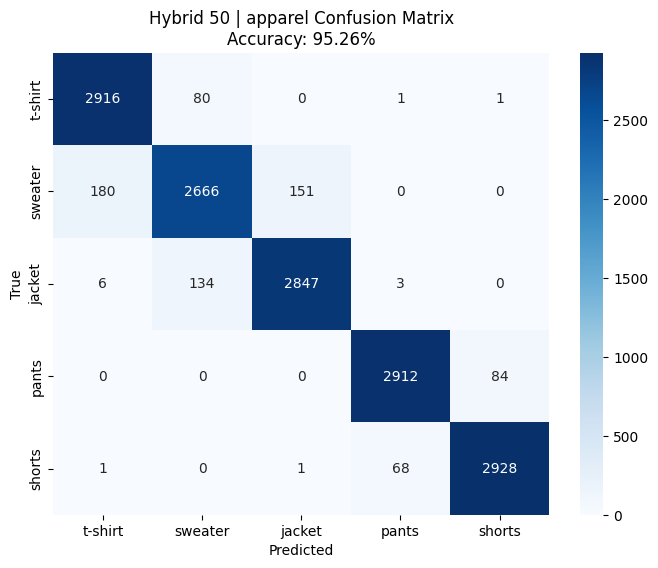

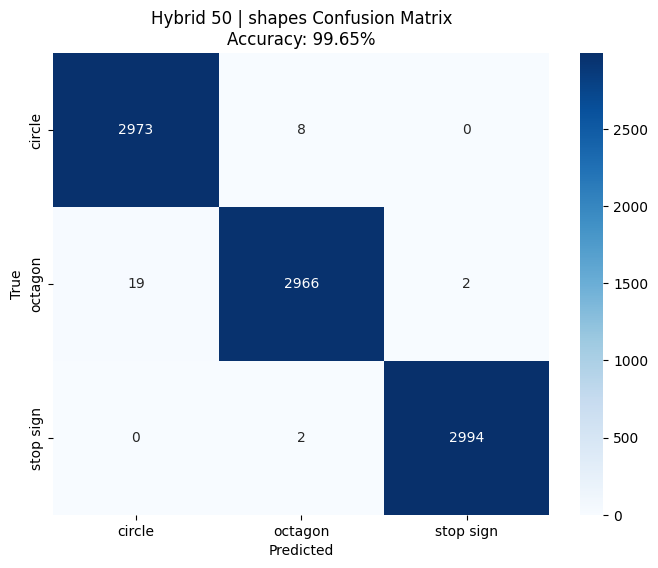

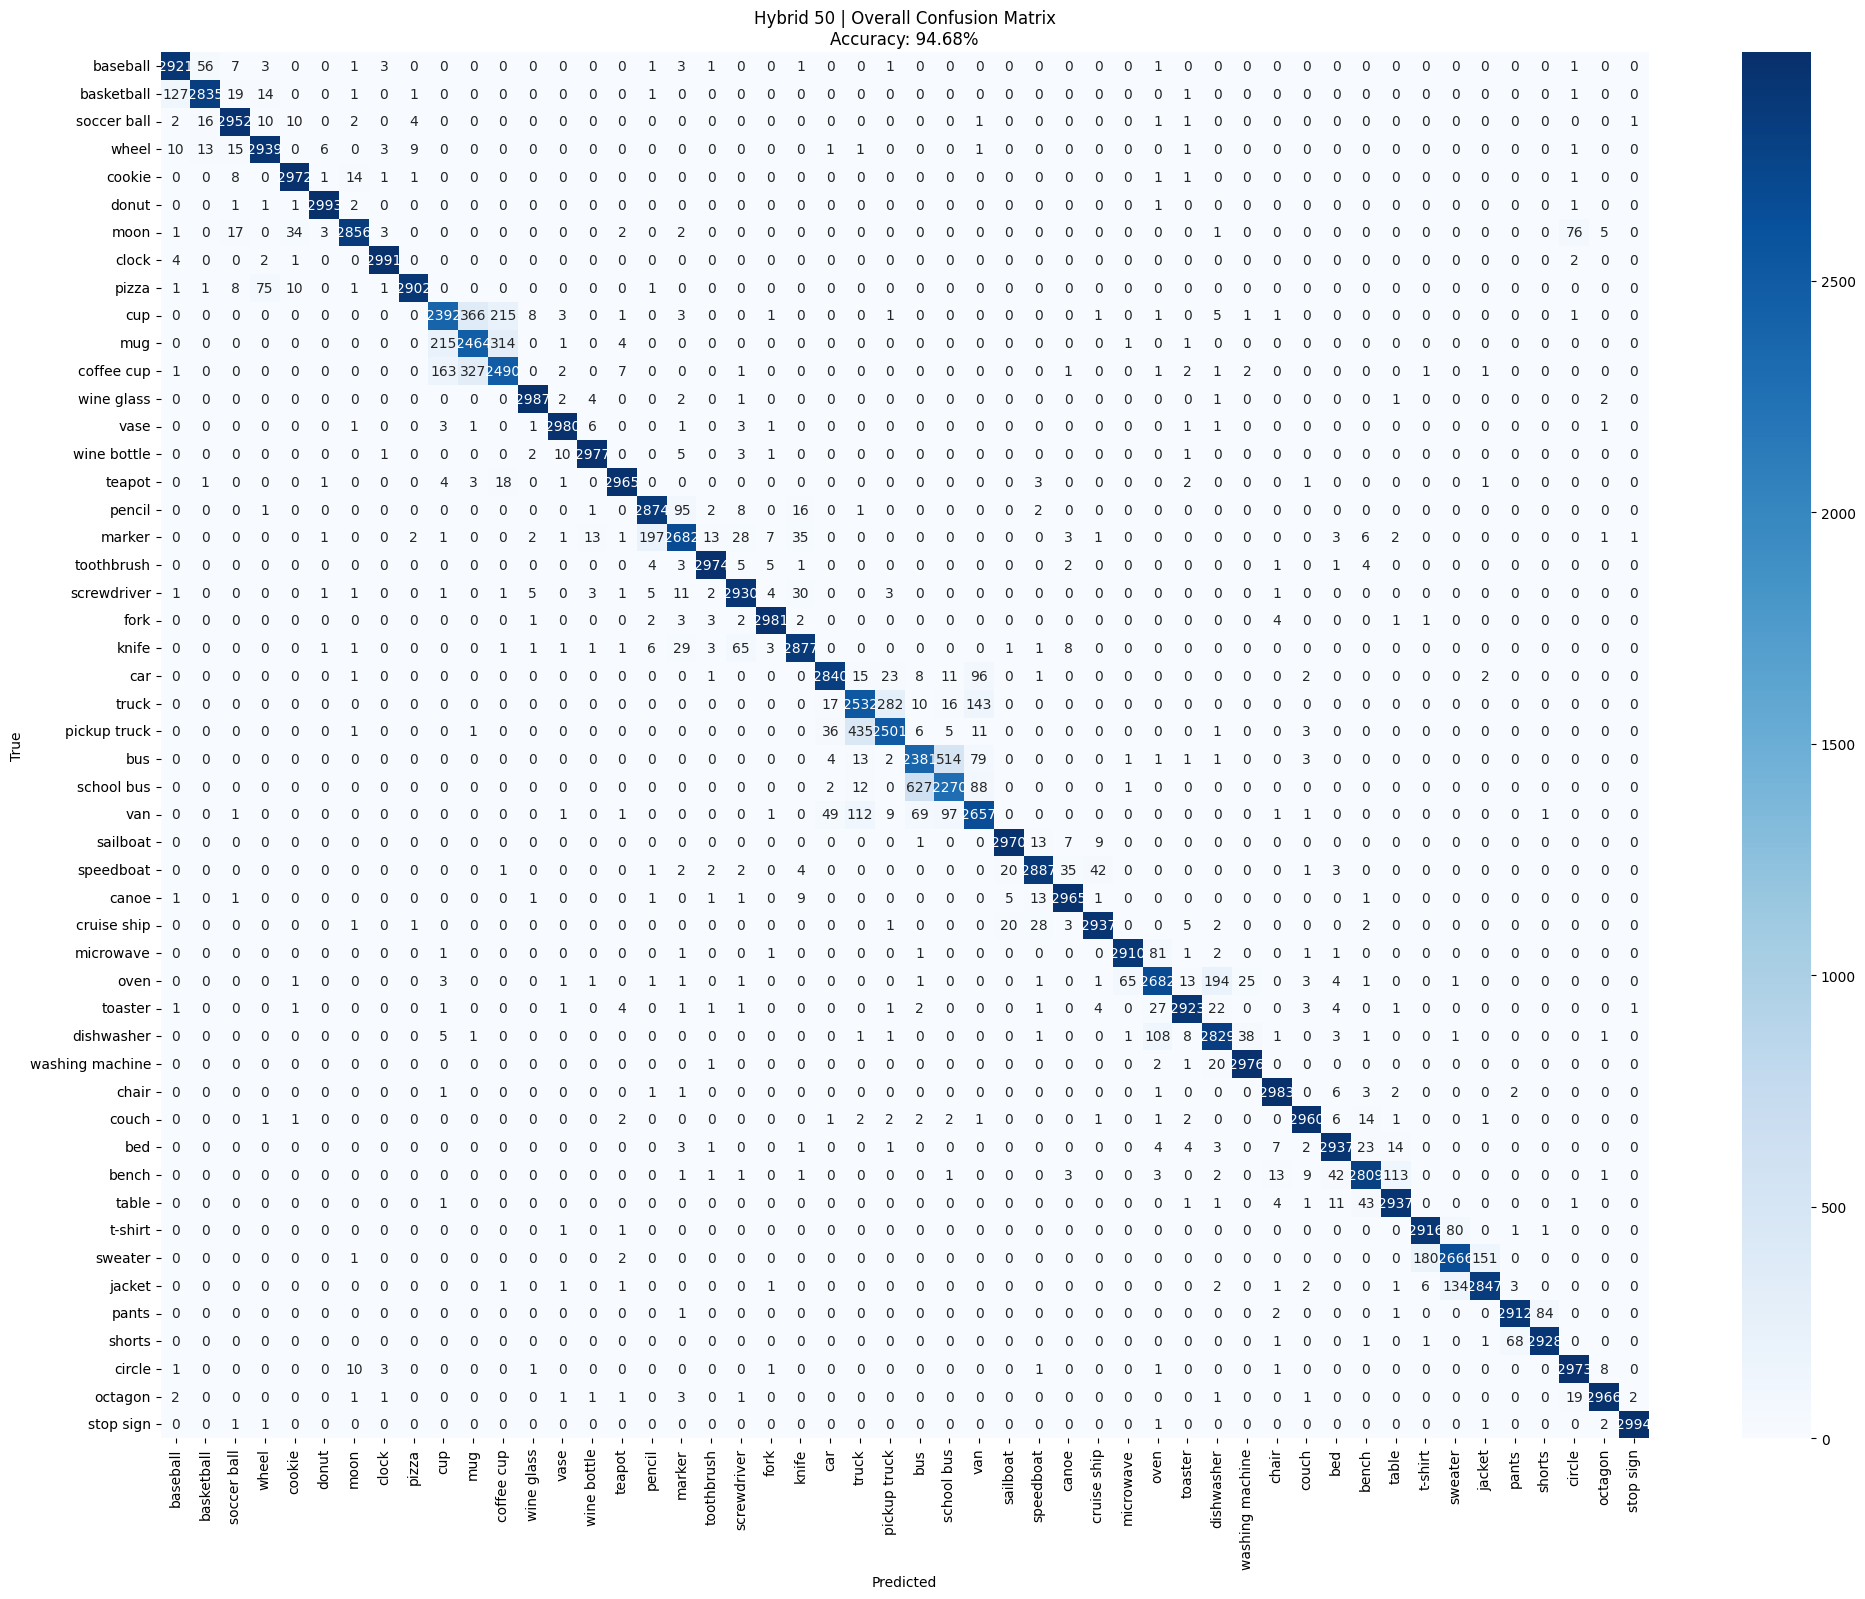

In [36]:
for group, label_map in FILTERED_LABEL_MAP.items():
    class_names = list(label_map.keys())
    class_ids = list(label_map.values())

    mask = np.isin(y_true, class_ids)

    y_true_group = y_true[mask]
    y_pred_group = hybrid_y_pred[mask]

    plot_confusion_matrix(y_true_group, y_pred_group, class_ids, class_names, f"Hybrid 50 | {group} Confusion Matrix")

# Global (50 classes) confusion matrix
mask_50 = np.isin(y_true, class_ids_50)

y_true_50 = y_true[mask_50]
hybrid_y_pred_50 = hybrid_y_pred[mask_50]

plot_confusion_matrix(
    y_true_50,
    hybrid_y_pred_50,
    class_ids_50,
    class_names_50,
    "Hybrid 50 | Overall Confusion Matrix",
    figsize=(24, 18),
)

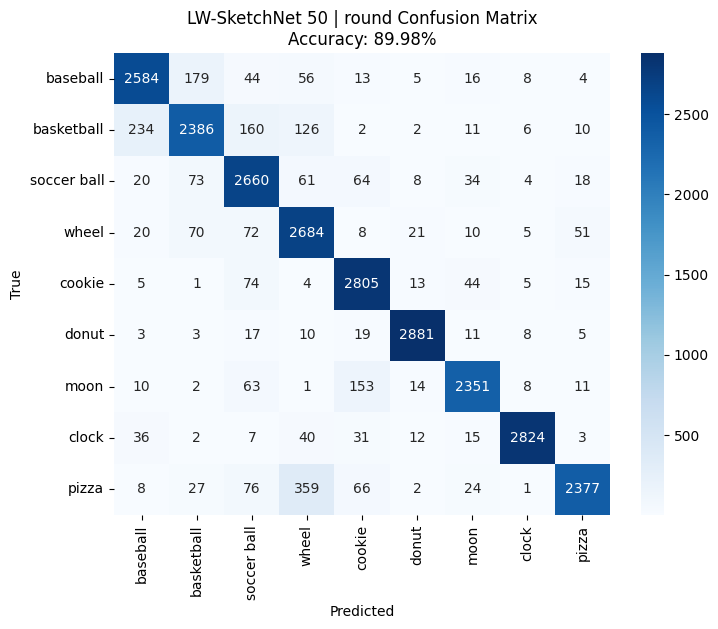

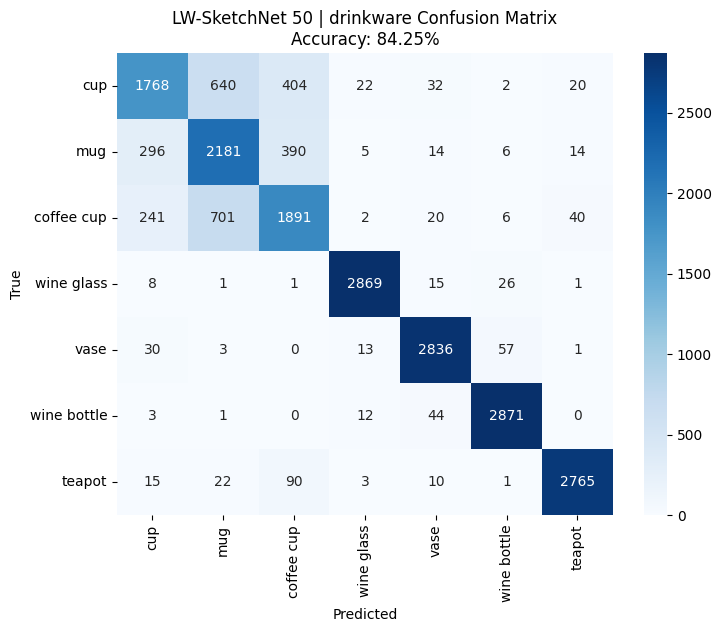

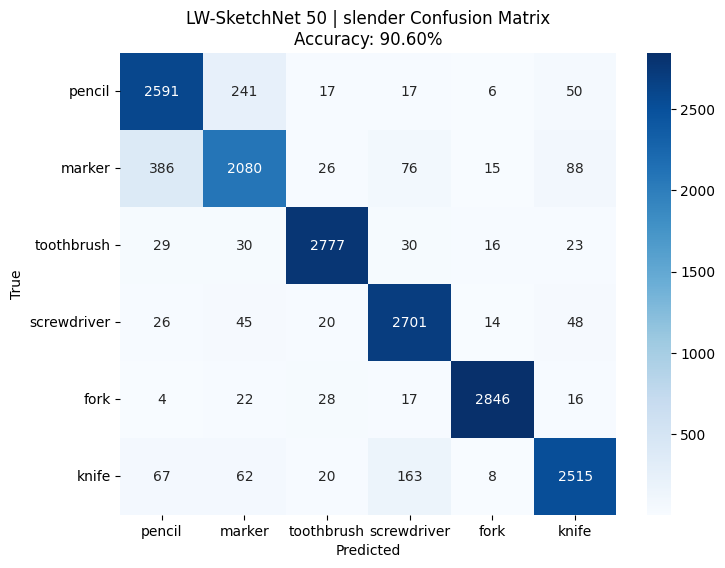

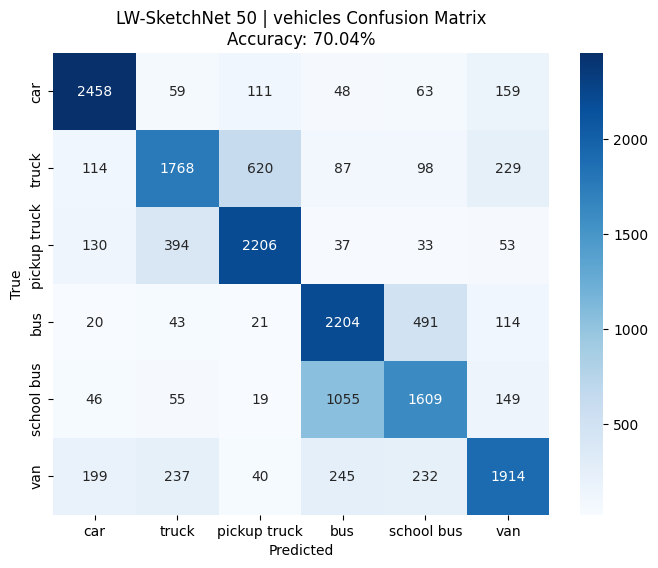

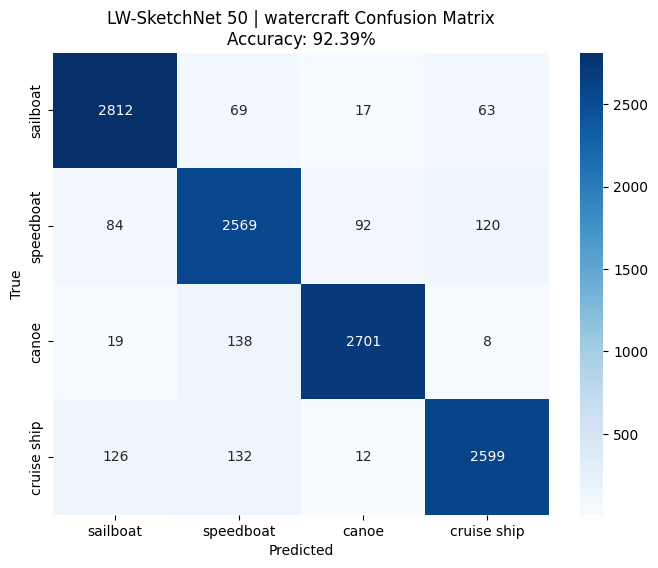

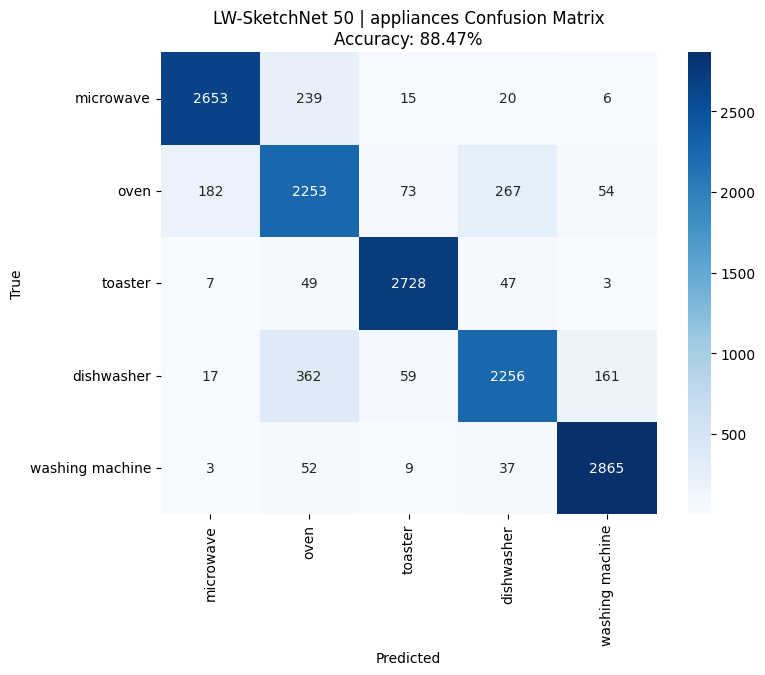

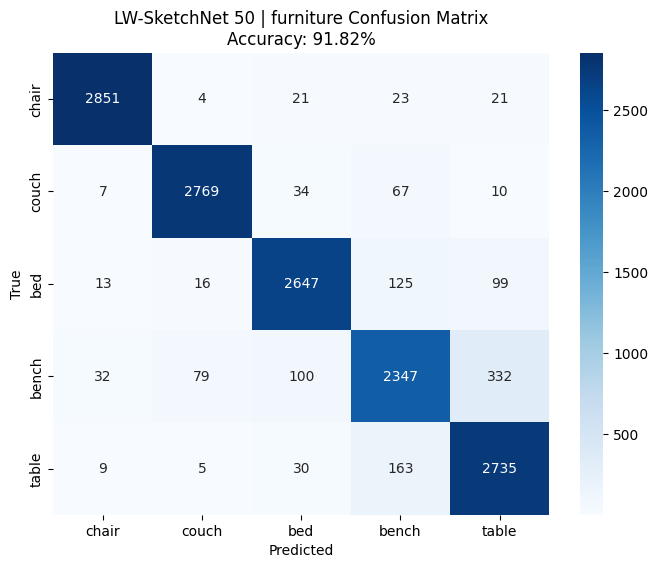

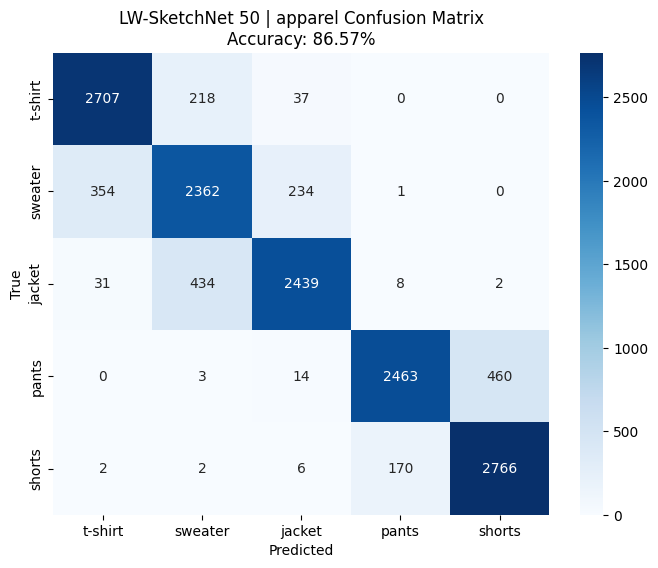

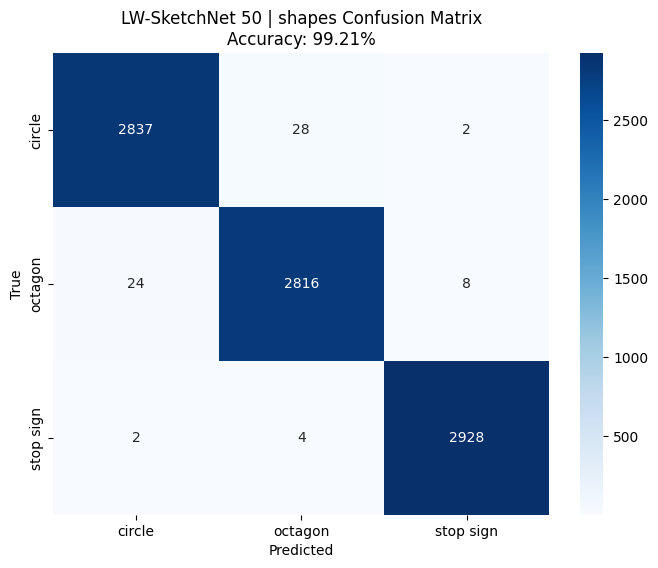

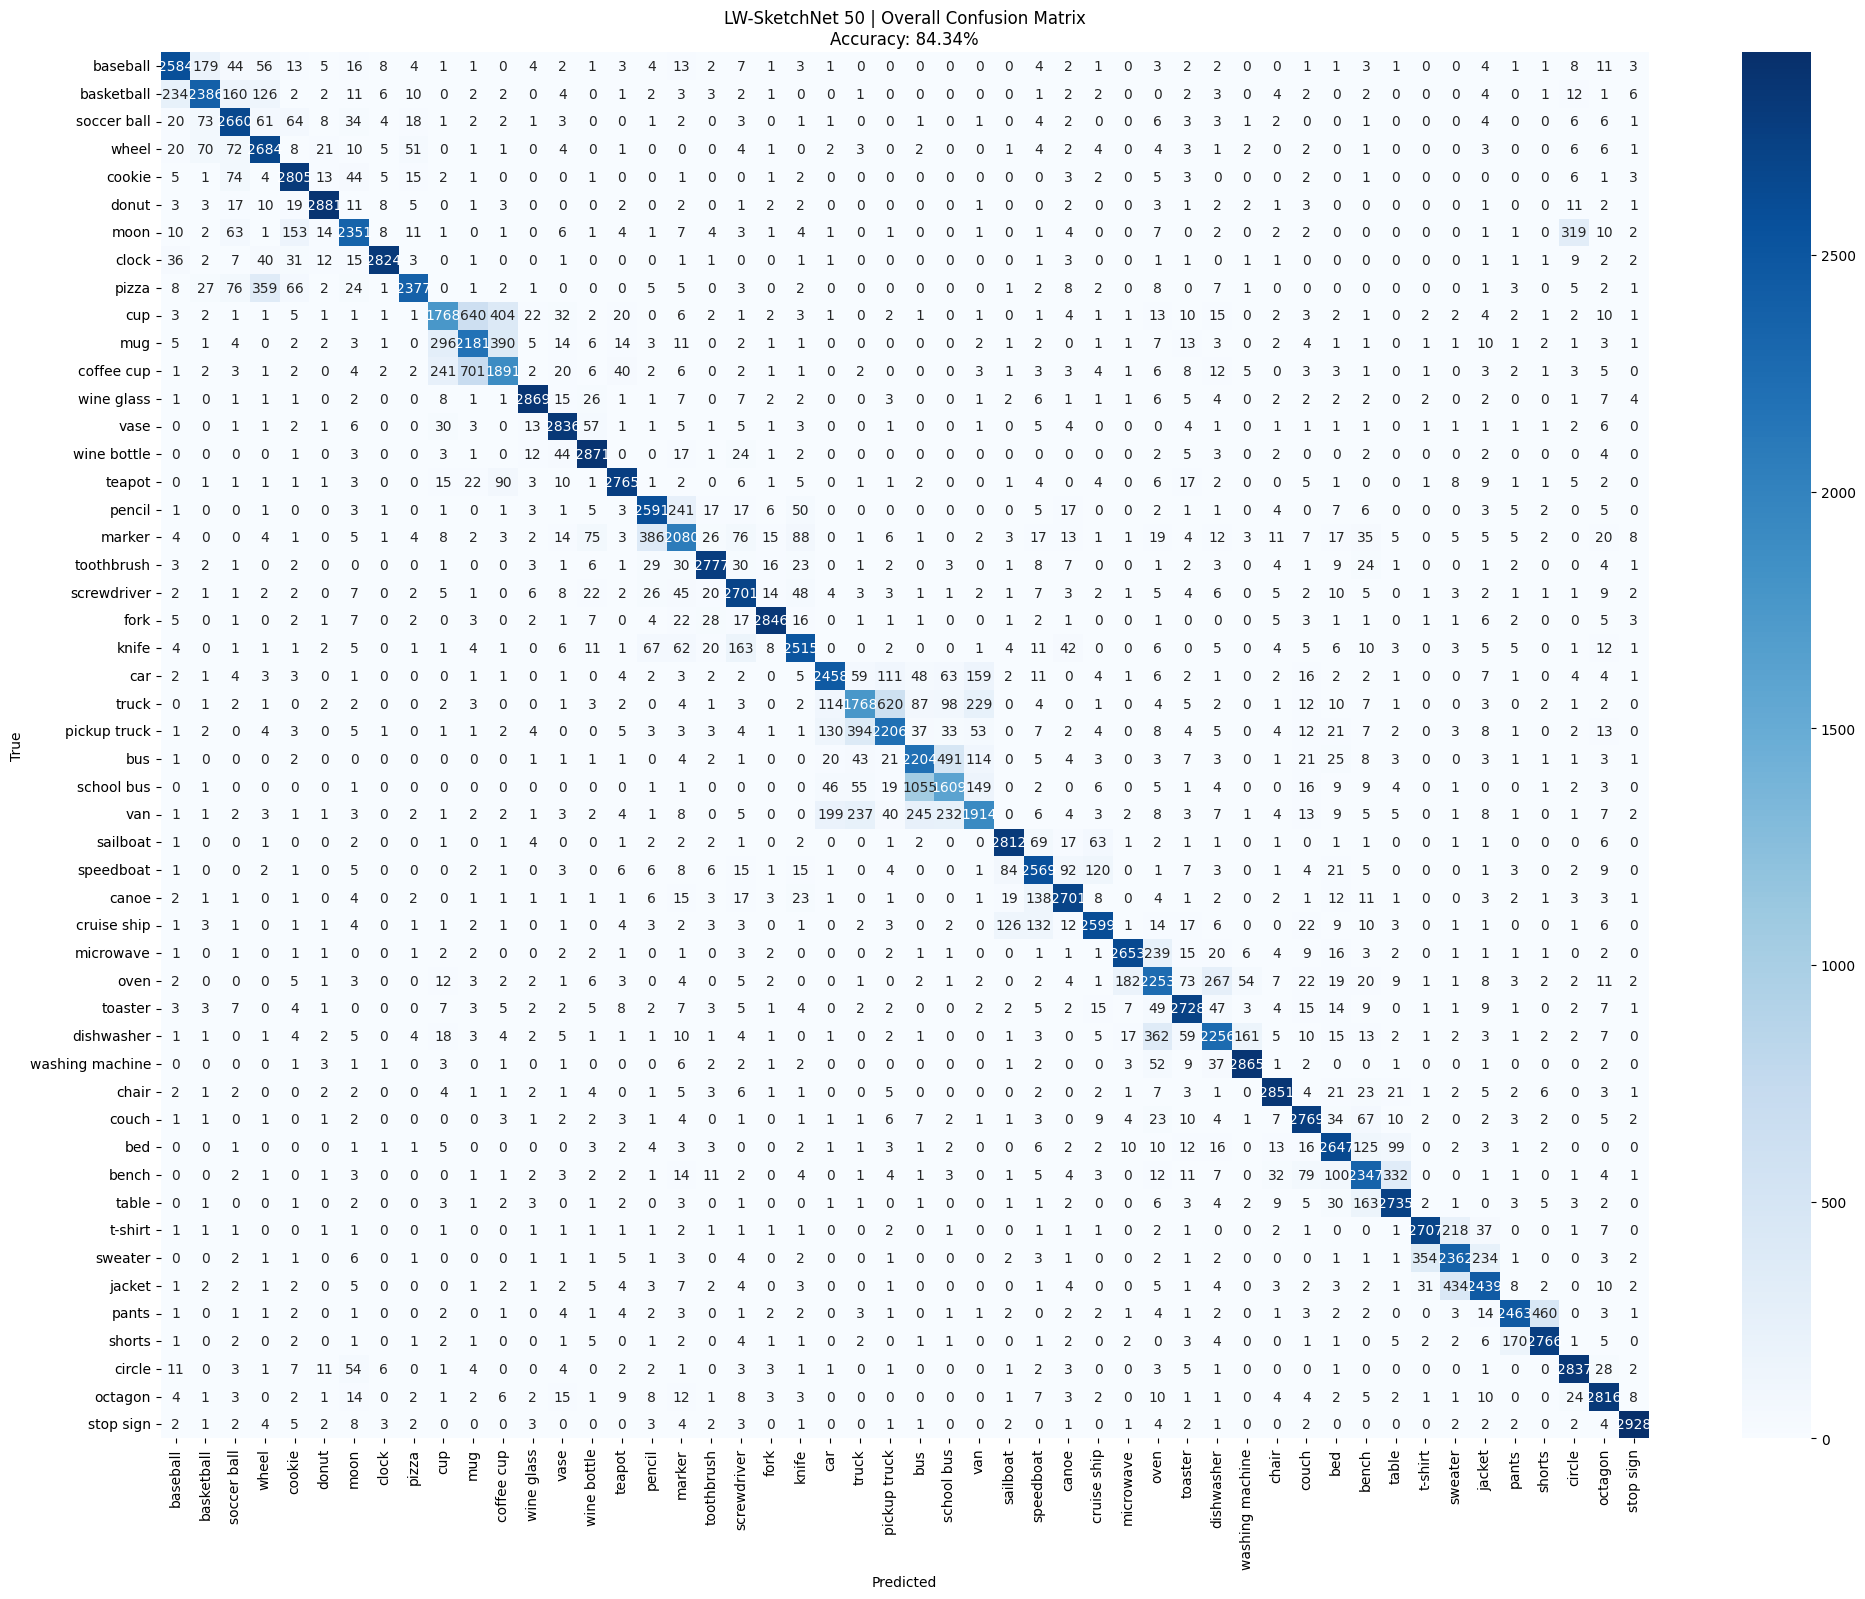

In [37]:
for group, label_map in FILTERED_LABEL_MAP.items():
    class_names = list(label_map.keys())
    class_ids = list(label_map.values())

    mask = np.isin(y_true, class_ids)

    y_true_group = y_true[mask]
    y_pred_group = lw_sketchnet_y_pred[mask]

    plot_confusion_matrix(y_true_group, y_pred_group, class_ids, class_names, f"LW-SketchNet 50 | {group} Confusion Matrix")

# Global (50 classes) confusion matrix
mask_50 = np.isin(y_true, class_ids_50)

y_true_50 = y_true[mask_50]
lw_sketchnet_y_pred_50 = lw_sketchnet_y_pred[mask_50]

plot_confusion_matrix(
    y_true_50,
    lw_sketchnet_y_pred_50,
    class_ids_50,
    class_names_50,
    "LW-SketchNet 50 | Overall Confusion Matrix",
    figsize=(24, 18),
)